In [ ]:
import pandas as pd
import numpy  as np
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats.stats import pearsonr

#from jyquickhelper import add_notebook_menu
#add_notebook_menu()

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
from scipy import stats

sns.set_style('whitegrid')

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (11,7)

# Permet aux graphiques de s'afficher dans le notebook
%matplotlib inline
from sklearn.impute import SimpleImputer
import re

import warnings
warnings.filterwarnings('ignore')

import qgrid

dataPath = '/home/romain/Documents/OC_projets/adv/'
resPath  = '/home/romain/Documents/OC_projets/tab_res/'

customers    = pd.read_csv(dataPath+'customers.csv')
products     = pd.read_csv(dataPath+'products.csv')
transactions = pd.read_csv(dataPath+'transactions.csv')


In [ ]:
products.loc[products['id_prod'] == '0_2245']

In [92]:
customers.head(2)

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975


In [93]:
products.head(2)

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0


In [94]:
transactions.head(2)

,id_prod,date,session_id,client_id
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277


In [95]:
import qgrid
widget_t = qgrid.show_grid(transactions, show_toolbar=True)
widget_t

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [96]:
#import qgrid
widget_p = qgrid.show_grid(products, show_toolbar=True)
widget_p

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [97]:
widget_c = qgrid.show_grid(customers, show_toolbar=True)
widget_c

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

# Mission 1

## Nettoyage des tables sources

In [98]:
# Valeurs manquantes dans les tables des clients, des produits et des ventes

print("\nNombre de valeurs 'null' dans la table 'customers' :",     customers.isnull().sum())

print("\nNombre de valeurs 'null' dans la table 'products' :",      products.isnull().sum())

print("\nNombre de valeurs 'null' dans la table 'transactions' :",  transactions.isnull().sum())



Nombre de valeurs 'null' dans la table 'customers' : client_id    0
sex          0
birth        0
dtype: int64

Nombre de valeurs 'null' dans la table 'products' : id_prod    0
price      0
categ      0
dtype: int64

Nombre de valeurs 'null' dans la table 'transactions' : id_prod       0
date          0
session_id    0
client_id     0
dtype: int64


In [99]:
# ================================================================================  Nettoyage des tables ==============================================================================================

# 1 - client_id doit être de format 'c_[d]' ie c suivi d'un '_' puis d'un nombre ===> Nettoyage des 'client_id' de type 'ct_'

clts = customers[(customers['client_id'].str.contains('^c_\d') == True)]

#clts = clients[(clients['client_id'] != 'ct_0') &  (clients['client_id'] != 'ct_1')]


# 2 - id_prod doit être de format'0_[d]' ou '1_[d]' ou 2_[d] ie un 0 ou 1 ou 2 suivi d'un '_' puis d'un nombre ===> nettoyage des 'id_prod' de type 'T_0'

# p = produits[(produits['id_prod'].str.contains('^0.*') == True) | (produits['id_prod'].str.contains('^1.*') == True) | (produits['id_prod'].str.contains('^2.*') == True)]

prod = products[(products['id_prod'].str.contains('^[0,1,2]_\d') == True)]


# 3 - Nettoyage des 'id_prod' de type 'T_0' dans la table des transactions

vtes = transactions[(transactions['id_prod'].str.contains('^[0,1,2]_\d') == True)]

# Affichage du nombre de valeurs avant et après nettoyage

print('\n=============  Nombre de valeurs dans les tables avant nettoyage  ==============\n')


print('\nNombre de valeurs dans la table "customers"    :', len(customers.index) )
print('Nombre de valeurs dans la table "products"     :',   len(products.index) )
print('Nombre de valeurs dans la table "transactions" :',   len(transactions.index) )

print('\n=============  Nombre de valeurs dans les tables après nettoyage  ==============\n')

print('Nombre de valeurs dans la table "clients"      :', len(clts.index) )
print('Nombre de valeurs dans la table "produits"     :', len(prod.index) )
print('Nombre de valeurs dans la table "ventes"       :', len(vtes.index) )


=============  Nombre de valeurs dans les tables avant nettoyage  ==============


Nombre de valeurs dans la table "customers"    : 8623
Nombre de valeurs dans la table "products"     : 3287
Nombre de valeurs dans la table "transactions" : 337016

=============  Nombre de valeurs dans les tables après nettoyage  ==============

Nombre de valeurs dans la table "clients"      : 8621
Nombre de valeurs dans la table "produits"     : 3286
Nombre de valeurs dans la table "ventes"       : 336816


In [100]:
# Fusion de la table des produits avec celle des ventes
#data_merged = pd.merge(data, population, on=['codePays', 'annee'], how = 'left')

vtes_ca = pd.merge(vtes, prod, on = ['id_prod']) 
# vtes_ca = pd.merge(vtes, prod) #336713

vtes_ca.shape

(336713, 6)

In [101]:
# Nombre de clients
#clts.groupby('client_id').sum()
#clts['client_id'].drop_duplicates()

In [102]:
# Création d'une table globale contenant les données de clients, de produits et de ventes

tab_globale = pd.merge(vtes_ca, clts, on = 'client_id')
#tab_globale

tab_globale_reorg = tab_globale[['date','session_id','client_id','sex','birth','id_prod','categ','price']]
print('\nTable globale contenant les données de clients, de produits et de ventes:\n')
tab_globale_reorg


Table globale contenant les données de clients, de produits et de ventes:



,date,session_id,client_id,sex,birth,id_prod,categ,price
0,2021-04-10 18:37:28.723910,s_18746,c_4450,f,1977,0_1483,0,4.99
1,2021-09-29 11:14:59.793823,s_97382,c_4450,f,1977,0_1085,0,3.99
2,2021-08-27 19:50:46.796939,s_81509,c_4450,f,1977,0_1453,0,7.99
3,2021-08-27 20:07:25.878440,s_81509,c_4450,f,1977,0_1405,0,4.99
4,2021-12-28 11:45:04.072281,s_141302,c_4450,f,1977,0_1392,0,6.30
...,...,...,...,...,...,...,...,...
336708,2021-09-25 07:26:00.224331,s_95185,c_4786,f,1967,1_607,1,26.99
336709,2021-06-01 00:49:49.781631,s_42350,c_2793,m,1933,1_673,1,12.99
336710,2021-10-09 09:03:48.268536,s_102200,c_2793,m,1933,0_2075,0,8.99
336711,2021-09-15 19:42:08.596375,s_90430,c_4478,f,1970,0_1692,0,13.36


In [103]:
# Panier par session d'achat

ca_session = tab_globale_reorg.groupby('session_id').sum()

tab_ca = ca_session.drop(['birth','categ'], axis = 1)
tab_ca.rename(columns = {'price':'panier_moyen'}, inplace = True)
tab_ca

,panier_moyen
session_id,
s_1,11.99
s_10,26.99
s_100,33.72
s_1000,39.22
s_10000,41.49
...,...
s_99994,28.92
s_99995,19.84
s_99996,56.27


In [104]:
# Fusion de la tables des ventes groupées par session avec celle des ventes pour avoir le CA par session

data_ventes = pd.merge(tab_globale_reorg, tab_ca, on = 'session_id')
data_ventes

,date,session_id,client_id,sex,birth,id_prod,categ,price,panier_moyen
0,2021-04-10 18:37:28.723910,s_18746,c_4450,f,1977,0_1483,0,4.99,24.97
1,2021-04-10 18:25:09.319011,s_18746,c_4450,f,1977,1_685,1,15.99,24.97
2,2021-04-10 18:32:27.342375,s_18746,c_4450,f,1977,0_1395,0,3.99,24.97
3,2021-09-29 11:14:59.793823,s_97382,c_4450,f,1977,0_1085,0,3.99,16.35
4,2021-09-29 11:09:40.816793,s_97382,c_4450,f,1977,0_2232,0,8.94,16.35
...,...,...,...,...,...,...,...,...,...
336708,2021-09-25 07:26:00.224331,s_95185,c_4786,f,1967,1_607,1,26.99,26.99
336709,2021-06-01 00:49:49.781631,s_42350,c_2793,m,1933,1_673,1,12.99,12.99
336710,2021-10-09 09:03:48.268536,s_102200,c_2793,m,1933,0_2075,0,8.99,8.99
336711,2021-09-15 19:42:08.596375,s_90430,c_4478,f,1970,0_1692,0,13.36,13.36


In [105]:
# Calcul de l'âge des clients

YEAR = 2021 # Nous sommes en 2021
data_ventes['age'] = YEAR - data_ventes['birth'] # calcul de l'âge des clients

data_ventes

,date,session_id,client_id,sex,birth,id_prod,categ,price,panier_moyen,age
0,2021-04-10 18:37:28.723910,s_18746,c_4450,f,1977,0_1483,0,4.99,24.97,44
1,2021-04-10 18:25:09.319011,s_18746,c_4450,f,1977,1_685,1,15.99,24.97,44
2,2021-04-10 18:32:27.342375,s_18746,c_4450,f,1977,0_1395,0,3.99,24.97,44
3,2021-09-29 11:14:59.793823,s_97382,c_4450,f,1977,0_1085,0,3.99,16.35,44
4,2021-09-29 11:09:40.816793,s_97382,c_4450,f,1977,0_2232,0,8.94,16.35,44
...,...,...,...,...,...,...,...,...,...,...
336708,2021-09-25 07:26:00.224331,s_95185,c_4786,f,1967,1_607,1,26.99,26.99,54
336709,2021-06-01 00:49:49.781631,s_42350,c_2793,m,1933,1_673,1,12.99,12.99,88
336710,2021-10-09 09:03:48.268536,s_102200,c_2793,m,1933,0_2075,0,8.99,8.99,88
336711,2021-09-15 19:42:08.596375,s_90430,c_4478,f,1970,0_1692,0,13.36,13.36,51


In [106]:

# Transformation en format date de la variable date
# Création de la variable 'date_achat'

data_ventes['date_achat'] = pd.to_datetime(data_ventes['date'])

# Suppression de la variable 'date'

data_ventes.drop('date', axis = 1, inplace = True)
data_ventes

,session_id,client_id,sex,birth,id_prod,categ,price,panier_moyen,age,date_achat
0,s_18746,c_4450,f,1977,0_1483,0,4.99,24.97,44,2021-04-10 18:37:28.723910
1,s_18746,c_4450,f,1977,1_685,1,15.99,24.97,44,2021-04-10 18:25:09.319011
2,s_18746,c_4450,f,1977,0_1395,0,3.99,24.97,44,2021-04-10 18:32:27.342375
3,s_97382,c_4450,f,1977,0_1085,0,3.99,16.35,44,2021-09-29 11:14:59.793823
4,s_97382,c_4450,f,1977,0_2232,0,8.94,16.35,44,2021-09-29 11:09:40.816793
...,...,...,...,...,...,...,...,...,...,...
336708,s_95185,c_4786,f,1967,1_607,1,26.99,26.99,54,2021-09-25 07:26:00.224331
336709,s_42350,c_2793,m,1933,1_673,1,12.99,12.99,88,2021-06-01 00:49:49.781631
336710,s_102200,c_2793,m,1933,0_2075,0,8.99,8.99,88,2021-10-09 09:03:48.268536
336711,s_90430,c_4478,f,1970,0_1692,0,13.36,13.36,51,2021-09-15 19:42:08.596375


In [107]:
# Découpage de la date de transaction en année et mois

data_ventes['annee_achat'] = data_ventes['date_achat'].dt.year
data_ventes['mois_achat']  = data_ventes['date_achat'].dt.month
#tab_globale_reorg['jour_achat'] = tab_globale_reorg['date_achat'].dt.day

data_ventes = data_ventes[['annee_achat','mois_achat','session_id','client_id','sex',
                           'id_prod','categ','price','panier_moyen','age']]
#tab_globale_reorg.drop('date_achat', axis = 1, inplace = True)
print('\n==========================================  La table globale des transactions ==================================\n')
data_ventes.to_csv(resPath+'data_ventes.csv')

# Conversion du type des données en float

data_ventes["panier_moyen"] = data_ventes["panier_moyen"].astype(float)
data_ventes["price"] = data_ventes["price"].astype(float)
data_ventes["age"] = data_ventes["age"].astype(int)
data_ventes["age"] = round(data_ventes["age"])

data = data_ventes[['annee_achat','mois_achat','id_prod','categ','price','panier_moyen','session_id','sex','age']]
data.to_csv(resPath+'data.csv')
data_ventes.to_csv(resPath+'data_ventes.csv')
#df_tab_globale_reorg = pd.DataFrame(tab_globale_reorg)
#df_tab_globale_reorg
#tab_globale_reorg
data.head()


==========================================  La table globale des transactions ==================================



,annee_achat,mois_achat,id_prod,categ,price,panier_moyen,session_id,sex,age
0,2021,4,0_1483,0,4.99,24.97,s_18746,f,44
1,2021,4,1_685,1,15.99,24.97,s_18746,f,44
2,2021,4,0_1395,0,3.99,24.97,s_18746,f,44
3,2021,9,0_1085,0,3.99,16.35,s_97382,f,44
4,2021,9,0_2232,0,8.94,16.35,s_97382,f,44


In [108]:
# Regroupement des âges par tranches

data['groupe_age'] = pd.cut(data['age'], bins=[17, 30, 45, 60, 92]
                    ,labels=['jeunes', ' adultes','senior', 'pers_ages'])
data

,annee_achat,mois_achat,id_prod,categ,price,panier_moyen,session_id,sex,age,groupe_age
0,2021,4,0_1483,0,4.99,24.97,s_18746,f,44,adultes
1,2021,4,1_685,1,15.99,24.97,s_18746,f,44,adultes
2,2021,4,0_1395,0,3.99,24.97,s_18746,f,44,adultes
3,2021,9,0_1085,0,3.99,16.35,s_97382,f,44,adultes
4,2021,9,0_2232,0,8.94,16.35,s_97382,f,44,adultes
...,...,...,...,...,...,...,...,...,...,...
336708,2021,9,1_607,1,26.99,26.99,s_95185,f,54,senior
336709,2021,6,1_673,1,12.99,12.99,s_42350,m,88,pers_ages
336710,2021,10,0_2075,0,8.99,8.99,s_102200,m,88,pers_ages
336711,2021,9,0_1692,0,13.36,13.36,s_90430,f,51,senior


## Traitement des valeurs manquantes

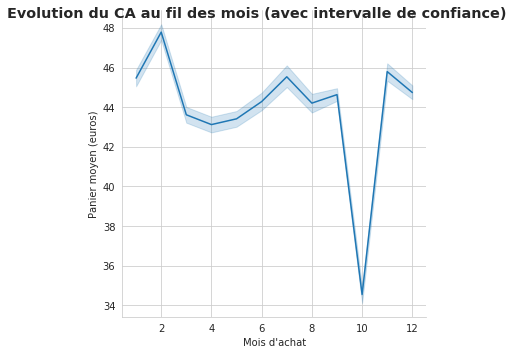

In [109]:
# Représentation graphique du panier moyen au fil des mois

fg = sns.relplot('mois_achat', 'panier_moyen', data=data, kind='line')
fg.fig.suptitle("Evolution du CA au fil des mois (avec intervalle de confiance)", 
            fontsize = 'x-large' , 
            fontweight = 'bold' ) 
# Set x-axis and y-axis labels 
fg.set_axis_labels( "Mois d'achat" , "Panier moyen (euros)" ) 

In [110]:
# Que s'est-il passé au mois d'octobre? Comment expliquer cette chute brutale des ventes?
# Le produit d'identifiant '0_2245' a effectivement été acheté. Néanmoins, son prix ne figure pas dans la table des produits. 
# Une solution consiste à remplacer ce prix par la moyenne des prix dans la table des transactions issue des différentes fusions.


In [111]:

data.loc[data['id_prod'] == '0_2245']

,annee_achat,mois_achat,id_prod,categ,price,panier_moyen,session_id,sex,age,groupe_age


In [112]:
widget_t

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [113]:
widget_p

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [114]:
# Remplacement des valeurs manquantes en octobre 2021

products = products.append({'id_prod':'0_2245','price':22.0,'categ':'1'},ignore_index=True)
products

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0
3,1_587,4.99,1
4,0_1507,3.99,0
...,...,...,...
3283,0_146,17.14,0
3284,0_802,11.22,0
3285,1_140,38.56,1
3286,0_1920,25.16,0


In [115]:
products.loc[products['id_prod'] == '0_2245']

,id_prod,price,categ
3287,0_2245,22.0,1


In [116]:
widget_pn = widget_p = qgrid.show_grid(products, show_toolbar=True)
widget_pn

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

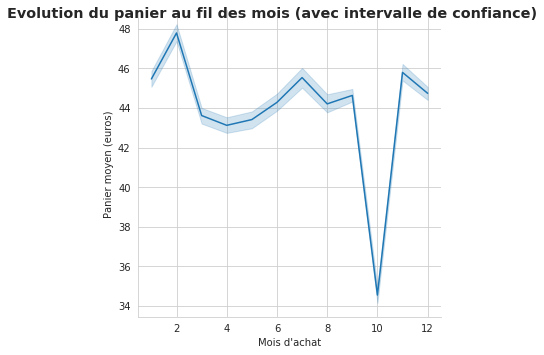

In [117]:
# CA au fil des mois
fgn = sns.relplot('mois_achat', 'panier_moyen', data=data, kind='line')
fgn.fig.suptitle("Evolution du panier au fil des mois (avec intervalle de confiance)", 
            fontsize = 'x-large' , 
            fontweight = 'bold' ) 
# Set x-axis and y-axis labels 
fgn.set_axis_labels( "Mois d'achat" , "Panier moyen (euros)" ) 

In [118]:
# Variables quantitatives  : CA (price),age
# Variables qualititatives : 
        # nominales : sex(binaire), categ
        # ordinales(ou semi-quantitatives) : anne_achat,mois_achat, groupe_age - diagramme en barres et as d'histogramme
data

,annee_achat,mois_achat,id_prod,categ,price,panier_moyen,session_id,sex,age,groupe_age
0,2021,4,0_1483,0,4.99,24.97,s_18746,f,44,adultes
1,2021,4,1_685,1,15.99,24.97,s_18746,f,44,adultes
2,2021,4,0_1395,0,3.99,24.97,s_18746,f,44,adultes
3,2021,9,0_1085,0,3.99,16.35,s_97382,f,44,adultes
4,2021,9,0_2232,0,8.94,16.35,s_97382,f,44,adultes
...,...,...,...,...,...,...,...,...,...,...
336708,2021,9,1_607,1,26.99,26.99,s_95185,f,54,senior
336709,2021,6,1_673,1,12.99,12.99,s_42350,m,88,pers_ages
336710,2021,10,0_2075,0,8.99,8.99,s_102200,m,88,pers_ages
336711,2021,9,0_1692,0,13.36,13.36,s_90430,f,51,senior


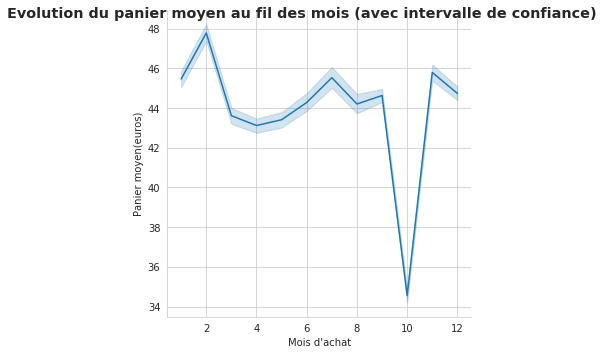

In [121]:
# CA au fil des mois
fg = sns.relplot('mois_achat', 'panier_moyen', data=data, kind='line')
fg.fig.suptitle("Evolution du panier moyen au fil des mois (avec intervalle de confiance)", 
            fontsize = 'x-large' , 
            fontweight = 'bold' ) 
# Set x-axis and y-axis labels 
fg.set_axis_labels( "Mois d'achat" , "Panier moyen(euros)" ) 

# Display the figure 
#plt.show() 

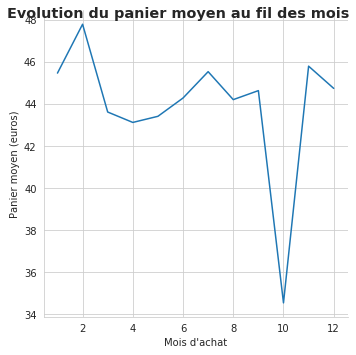

In [122]:
# CA au fil des mois
fg = sns.relplot('mois_achat', 'panier_moyen', data=data, kind='line', ci=None)
#fg = sns.relplot('mois_achat', 'CA', data=tab_globale_reorg, kind='line')
fg.fig.suptitle("Evolution du panier moyen au fil des mois", 
            fontsize = 'x-large' , 
            fontweight = 'bold' ) 
# Set x-axis and y-axis labels 
fg.set_axis_labels( "Mois d'achat" , "Panier moyen (euros)" ) 

# Display the figure 
plt.show() 

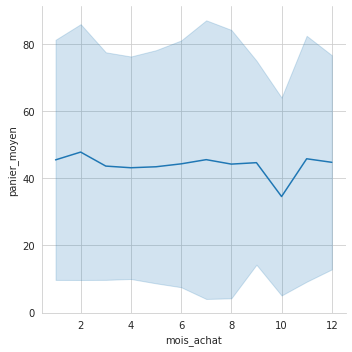

In [123]:
# CA au fil des mois avec  INTERVALLES DE CONFIANCE
sns.relplot('mois_achat', 'panier_moyen', data=data, kind='line', ci='sd')

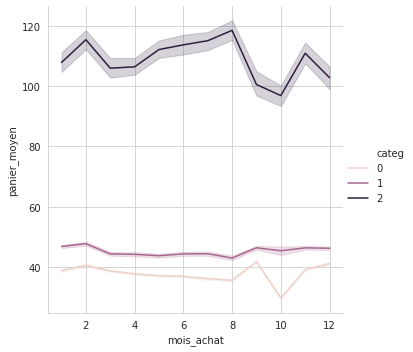

In [125]:
# Série temporelle par catégorie de produits

sns.relplot('mois_achat', 'panier_moyen', data=data, kind='line', hue = 'categ')
plt.show()

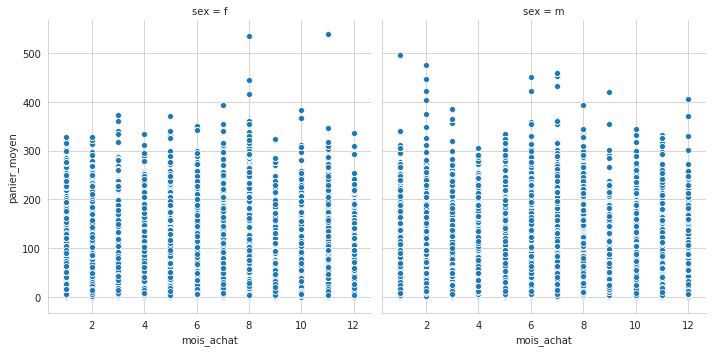

In [126]:
sns.relplot('mois_achat', 'panier_moyen', data=data, col = 'sex')
plt.show()

<Figure size 504x504 with 0 Axes>

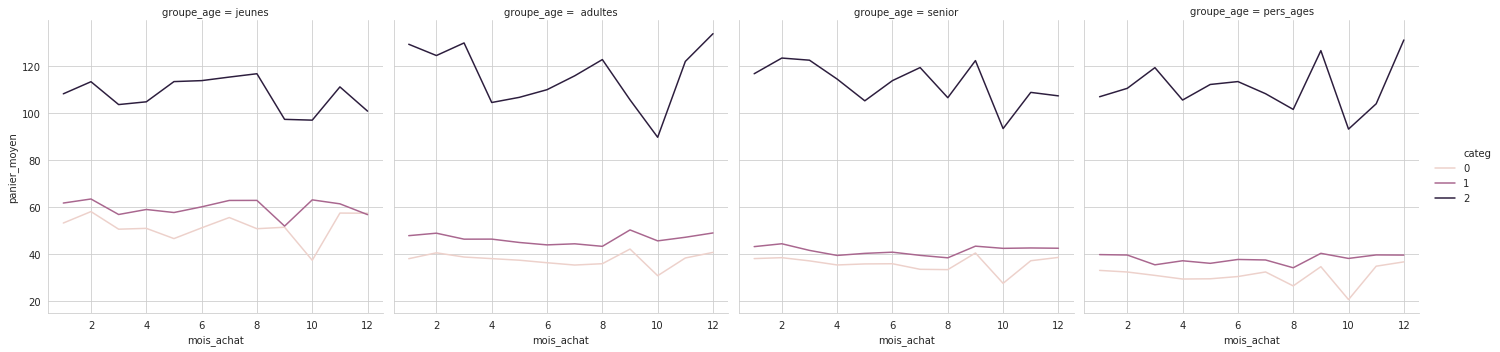

In [129]:
# Evolution du panier moyen par groupe d'âges au fil des mois

#plt.figure(figsize=(7,7))
sns.relplot('mois_achat', 'panier_moyen', data=data, kind='line', hue = 'categ', col = 'groupe_age', ci=None, col_wrap=4 )
plt.show()

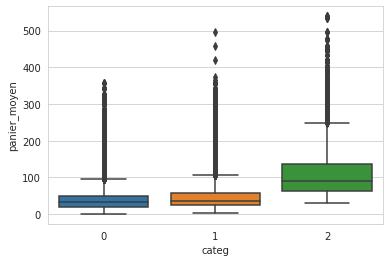

In [130]:
sns.boxplot(x='categ', y='panier_moyen', data=data)
plt.show()

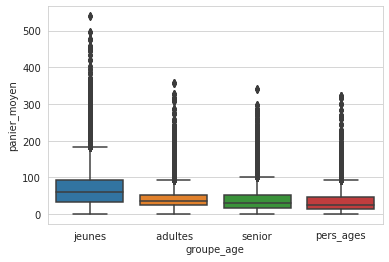

In [131]:
sns.boxplot(x='groupe_age', y='panier_moyen', data=data)

# Mission 2

## Indicateurs de tendance centrale

In [132]:
# Indicateurs de tendance centrale des clients

age_moyen  = round(data['age'].mean(),0)
age_median = round(data['age'].median(),0)
age_mode   = data['age'].mode()

print('\n================    Indicateurs de tendance centrale des clients   ================\n')

print('Age moyen des clients : {} ans'.format(age_moyen))
print('Age médian des clients : {} ans'.format(age_median))
print('Age modal des clients : {} ans'.format(age_mode))

# print('La valeur de la moyenne et celle de la médiane sont proches. Cela indique que la distribution des valeurs est symétrique.')

# Indicateurs de tendance centrale des produits

prix_moyen = round(prod['price'].mean(),0)
prix_median = round(prod['price'].median(),0)
prix_mode   = prod['price'].mode()

print('\n================    Indicateurs de tendance centrale des prix des produits   ================\n')

print('Prix moyen des produits : {} euros'.format(prix_moyen))
print('Prix médian des produits : {} euros'.format(prix_median))
print('Prix modal des produits : {} euros'.format(age_mode))

print('La valeur de la moyenne et celle de la médiane sont assez différentes. Cela indique la présence d\'individus extrêmes.')


# Indicateurs de tendance centrale des transactions

pan_moyen = round(data['panier_moyen'].mean(),0)
pan_median = round(data['panier_moyen'].median(),0)
pan_mode   = data['panier_moyen'].mode()

print('\n================    Indicateurs de tendance centrale des transactions   ================\n')
print('Montant moyen des transactions : {} euros'.format(pan_moyen))
print('Montant médian des transactions : {} euros'.format(pan_median))
print('Montant modal des transactions : {} euros'.format(pan_mode))



================    Indicateurs de tendance centrale des clients   ================

Age moyen des clients : 43.0 ans
Age médian des clients : 41.0 ans
Age modal des clients : 0    41
dtype: int64 ans

================    Indicateurs de tendance centrale des prix des produits   ================

Prix moyen des produits : 22.0 euros
Prix médian des produits : 13.0 euros
Prix modal des produits : 0    41
dtype: int64 euros
La valeur de la moyenne et celle de la médiane sont assez différentes. Cela indique la présence d'individus extrêmes.

================    Indicateurs de tendance centrale des transactions   ================

Montant moyen des transactions : 44.0 euros
Montant médian des transactions : 36.0 euros
Montant modal des transactions : 0    15.99
dtype: float64 euros


In [133]:
# Calcul du prix moyen des produits par catégorie
prix_categ = data[['categ','price']]
prix_categ['categ'] = prix_categ['categ'].astype(float).astype(int)
pg = prix_categ.groupby('categ').mean().round(2)
pg.rename(columns={'price':'prix_moyen'}, inplace=True)
print('\nPrix moyen prar catégorie de produits')
pg


Prix moyen prar catégorie de produits


,prix_moyen
categ,
0,10.65
1,20.48
2,75.17


In [134]:
pgi = pg.reset_index()
pgi

,categ,prix_moyen
0,0,10.65
1,1,20.48
2,2,75.17


## Indicateurs de dispersion

In [135]:
print('\n============= Indicateurs de dispersion des clients ===============\n')

# Quantile 0,25 : Q1
Q1 = round(np.percentile(data['age'], 25))
print("\nQuartile Q1 : ", Q1)

# Quantile 0,75 : quartile Q3
Q3 = round(np.percentile(data['age'], 75))
print("Quartile Q3 : ", round(np.percentile(data['age'], 75)))

# Ecart interquartile : Q3 - Q1
print("L'écart interquartile : ", Q3 - Q1)

variance = np.var(data['age'])
print ("\nLa variance du panier moyen : ", round(variance, 2))

ecartType = np.std(data['age'])
print ("L'écart type du age : ", round(ecartType, 2))

print('\n============= Indicateurs de dispersion des produits ===============\n')

# Quantile 0,25 : Q1
Q1 = round(np.percentile(data['price'], 25))
print("\nQuartile Q1 : ", Q1)

# Quantile 0,75 : quartile Q3
Q3 = round(np.percentile(data['price'], 75))
print("Quartile Q3 : ", round(np.percentile(data['price'], 75)))

# Ecart interquartile : Q3 - Q1
print("L'écart interquartile : ", Q3 - Q1)

variance = np.var(data['price'])
print ("\nLa variance du prix: ", round(variance, 2))

ecartType = np.std(data['price'])
print ("L'écart type du prix : ", round(ecartType, 2))

print('\n============= Indicateurs de dispersion des transactions ===============\n')

# Quantile 0,25 : Q1
Q1 = round(np.percentile(data['panier_moyen'], 25))
print("\nQuartile Q1 : ", Q1)

# Quantile 0,75 : quartile Q3
Q3 = round(np.percentile(data['panier_moyen'], 75))
print("Quartile Q3 : ", round(np.percentile(data['panier_moyen'], 75)))

# Ecart interquartile : Q3 - Q1
print("L'écart interquartile : ", Q3 - Q1)

variance = np.var(data['panier_moyen'])
print ("\nLa variance du panier moyen: ", round(variance, 2))

ecartType = np.std(data['panier_moyen'])
print ("L'écart type du panier moyen : ", round(ecartType, 2))


============= Indicateurs de dispersion des clients ===============


Quartile Q1 :  34.0
Quartile Q3 :  50.0
L'écart interquartile :  16.0

La variance du panier moyen :  182.91
L'écart type du age :  13.52

============= Indicateurs de dispersion des produits ===============


Quartile Q1 :  9.0
Quartile Q3 :  19.0
L'écart interquartile :  10.0

La variance du prix:  318.82
L'écart type du prix :  17.86

============= Indicateurs de dispersion des transactions ===============


Quartile Q1 :  22.0
Quartile Q3 :  56.0
L'écart interquartile :  34.0

La variance du panier moyen:  1249.2
L'écart type du panier moyen :  35.34


In [136]:
# Table des indicateurs de l'âge des clients

tab_indic_c = data['age']
tab_indic_c.describe()

count    336713.000000
mean         43.176432
std          13.524433
min          17.000000
25%          34.000000
50%          41.000000
75%          50.000000
max          92.000000
Name: age, dtype: float64

In [137]:
# Table des indicateurs de prix

tab_indic_v = data['price']
tab_indic_v.describe()


count    336713.000000
mean         17.215189
std          17.855445
min           0.620000
25%           8.610000
50%          13.900000
75%          18.990000
max         300.000000
Name: price, dtype: float64

In [138]:
# Table des indicateurs de prix

tab_indic_t = data['panier_moyen']
tab_indic_t.describe()

count    336713.000000
mean         44.132191
std          35.344083
min           0.620000
25%          21.640000
50%          35.910000
75%          55.850000
max         539.230000
Name: panier_moyen, dtype: float64

## Analyse de concentration, via une courbe de Lorenz et un indice de Gini

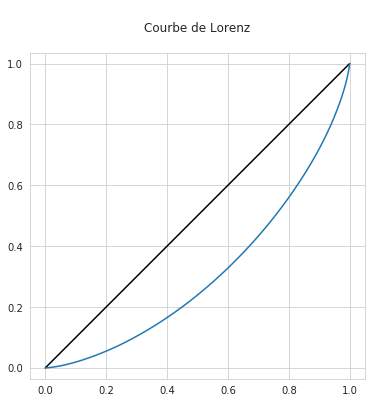


Indice de Gini: 0.38


In [139]:
plt.figure(figsize=(6,6))

n = len(data)
lorenz = np.cumsum(np.sort(data['panier_moyen']) / data['panier_moyen'].sum())
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0

plt.axes().axis('equal')
xaxis = np.linspace(0-1/n,1+1/n,n+1) #Il y a un segment de taille n pour chaque individu, plus 1 segment supplémentaire d'ordonnée 0. Le premier segment commence à 0-1/n, et le dernier termine à 1+1/n.

## line plot of equality
plt.plot([0,1], [0,1], color='K')
plt.plot(xaxis,lorenz,drawstyle='steps-post')
#plt.savefig(dataPath+'lorenz.png', transparent=True)
# plt.savefig("lorenz.jpg")

# export_png('df_styled.png)

# Coefficient de Gini
 
# Le coefficient de Gini est une mesure statistique qui donne une indication sur les disparités 
# dans une population. 
 
# 0 = égalité parfaite entre tous les participants dans une population quelconque
# 1 = inégalité totale
plt.title('\nCourbe de Lorenz\n')

AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # Surface sous la courbe de Lorenz. Le premier segment (lorenz[0]) est à moitié en dessous de 0, on le coupe donc en 2, on fait de même pour le dernier segment lorenz[-1] qui est à moitié au dessus de 1.
S = 0.5 - AUC                                     # surface entre la première bissectrice et le courbe de Lorenz
plt.savefig(dataPath+"lorenz.jpg")
plt.savefig(dataPath+"lorenz.png")
plt.show()

gini = round((2*S),2)
print('\nIndice de Gini: {}'.format(gini))

## Représentations graphiques

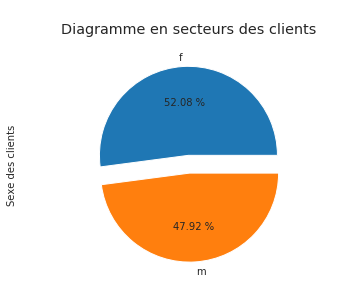

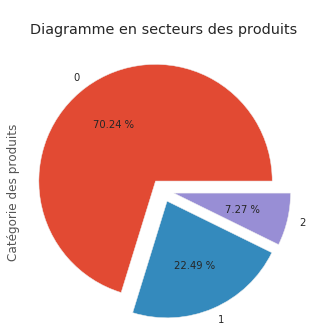

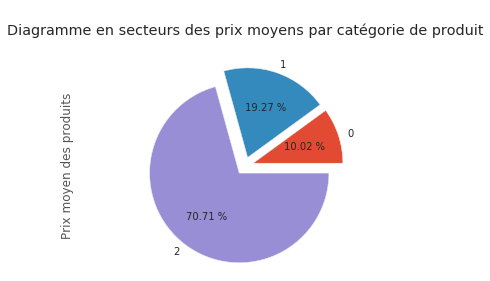

In [141]:
# VARIABLE QUALITATIVE - Diagramme en secteurs des clients

explode = (.1,.1)

clts["sex"].value_counts(normalize=True).plot(kind='pie',  autopct='%.2f %%', explode = explode)
plt.ylabel('Sexe des clients') 

# Cette ligne assure que le pie chart est un cercle plutôt qu'une éllipse
plt.style.use('ggplot')
plt.title('\nDiagramme en secteurs des clients\n')
plt.axis('equal') 


plt.savefig(dataPath+"secteurs_clts.jpg")
plt.savefig("secteurs_clts.png")
plt.show() 

plt.figure(figsize=(5,5))


# VARIABLE QUALITATIVE - Diagramme en secteurs des produits
explode = (.1,.1, .1)
prod["categ"].value_counts(normalize=True).plot(kind='pie',  autopct='%.2f %%' , explode = explode)
plt.title('\nDiagramme en secteurs des produits\n')
plt.ylabel('Catégorie des produits') 

# Cette ligne assure que le pie chart est un cercle plutôt qu'une éllipse
plt.axis('equal') 
plt.savefig(dataPath+"secteurs_prod.jpg")
plt.savefig("secteurs_prod.png")
plt.show() 


# VARIABLE QUALITATIVE - Diagramme en secteurs des produits
explode = (.1,.1, .1)
pgi["prix_moyen"].plot(kind='pie', autopct='%.2f %%', explode = explode)
plt.title('\nDiagramme en secteurs des prix moyens par catégorie de produit\n')
plt.ylabel('Prix moyen des produits') 

# Cette ligne assure que le pie chart est un cercle plutôt qu'une éllipse
plt.axis('equal') 
plt.savefig(dataPath+"secteurs_prix_moyen_prod.jpg")
plt.show() 

### Histogramme

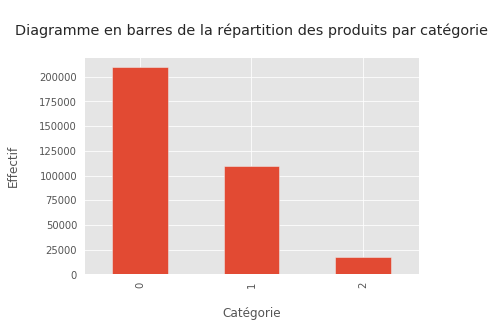

In [147]:
plt.title('\nDiagramme en barres de la répartition des produits par catégorie\n')
plt.xlabel('\nCatégorie')
plt.ylabel('Effectif\n')
data['categ'].value_counts().plot.bar()
plt.show()

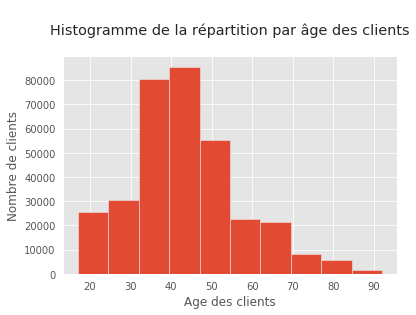

In [143]:
plt.title('\nHistogramme de la répartition par âge des clients\n')
plt.xlabel('Age des clients')
plt.ylabel('Nombre de clients')
data['age'].hist()
plt.savefig(dataPath+'hist_age.jpg')
plt.show()

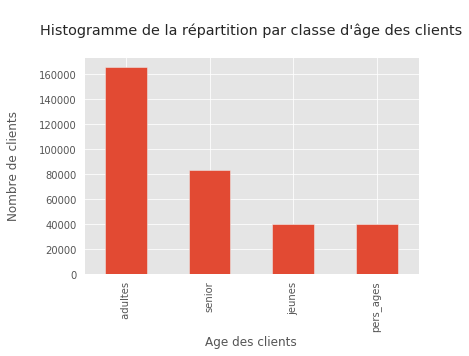

In [148]:
plt.title('\nHistogramme de la répartition par classe d\'âge des clients\n')

data['groupe_age'].value_counts().plot.bar()
plt.xlabel('Age des clients')
plt.ylabel('Nombre de clients\n')
plt.savefig(dataPath+'hist_age.jpg')
plt.show()

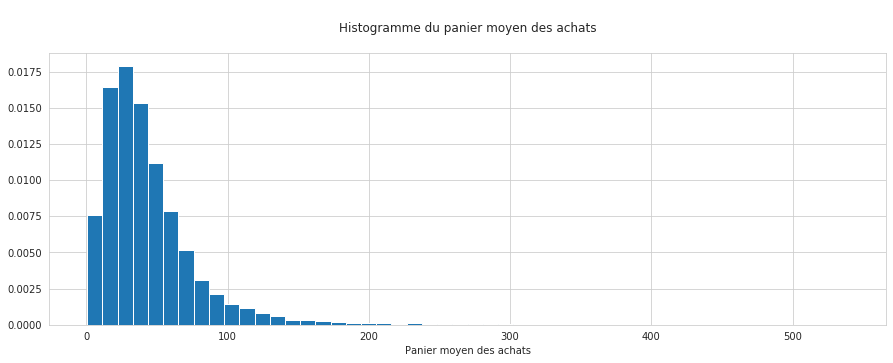

In [84]:
# Histogramme
# X["CA"].hist(density=True)
# plt.show()
sns.set_style('whitegrid')

plt.figure(figsize=(15,5))

plt.title('\nHistogramme du panier moyen des achats\n')

data["panier_moyen"].hist(density=True,bins=50)
plt.xlabel('Panier moyen des achats') 

plt.savefig(dataPath+'hist_panier_moy.jpg')
plt.savefig("hist_panier_moy.png")
plt.show()

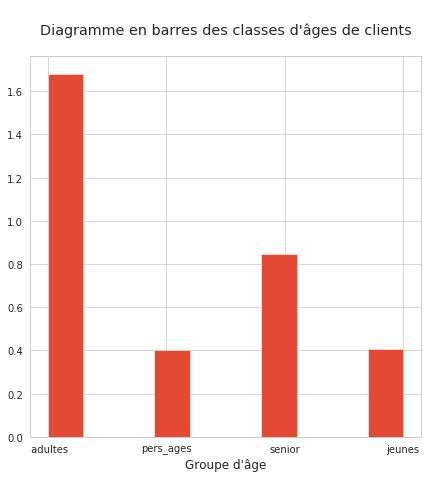

In [48]:
# Histogramme
sns.set_style('whitegrid')

plt.figure(figsize=(7,7))

plt.title('\nDiagramme en barres des classes d\'âges de clients\n')

ax = data["groupe_age"].hist(density=True)
ax.set(xlabel="Groupe d'âge")
plt.savefig(dataPath+"classes_ages.jpg")
plt.savefig("classes_ages.png")
plt.show()

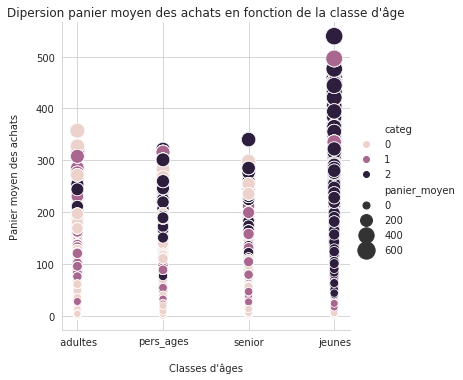

In [85]:
# CA en fonction de la tranche d'âge et de la catégorie
# sns.color_palette()
sns.set_style('whitegrid')
#sns.palplot()
sns.relplot('groupe_age', 'panier_moyen', data=data, hue='categ', size='panier_moyen', sizes = (50,300))          #, style='categ')
plt.xlabel('\nClasses d\'âges')
plt.ylabel('Panier moyen des achats\n')
#sns.set_title('Dipersion panier moyen des achats en fonction de la classe d\'âge')
plt.title("Dipersion panier moyen des achats en fonction de la classe d\'âge") 


plt.savefig(dataPath+'panier_classes_ages.jpg')
plt.savefig("panier_classes_ages.png")
plt.show()

### Boîte à moustaches

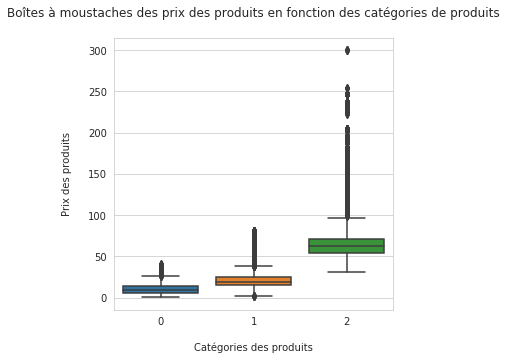

In [86]:
# Boîtes à moustaches prix en fonction des catégories de produits 
plt.figure(figsize=(5,5))
sns.boxplot(x='categ', y='price', data=data)

plt.title("Boîtes à moustaches des prix des produits en fonction des catégories de produits\n") 

plt.xlabel('\nCatégories des produits')
plt.ylabel('Prix des produits\n')

plt.savefig(dataPath+'prix_categ.jpg')
plt.savefig("prix_categ.png")

plt.show()

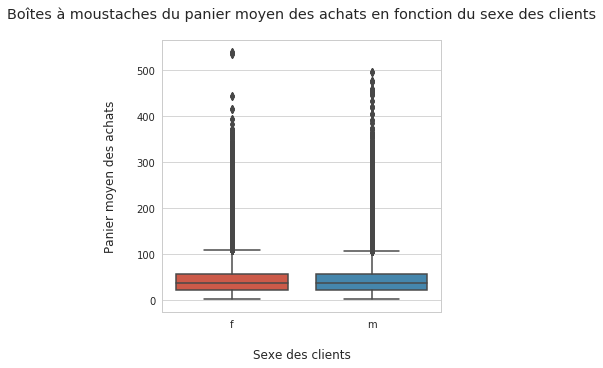

In [58]:
# Boîtes à moustaches du prix des produits en fonction du sexe des clients
sns.set_style('whitegrid')

plt.figure(figsize=(5,5))
sns.boxplot(x='sex', y='panier_moyen', data=data)

plt.title("Boîtes à moustaches du panier moyen des achats en fonction du sexe des clients\n") 

plt.xlabel('\nSexe des clients')
plt.ylabel('Panier moyen des achats\n')

plt.savefig(dataPath+"sex_panier_moyen.jpg")
plt.savefig("sex_panier_moyen.png")

plt.show()

### Série temporelle

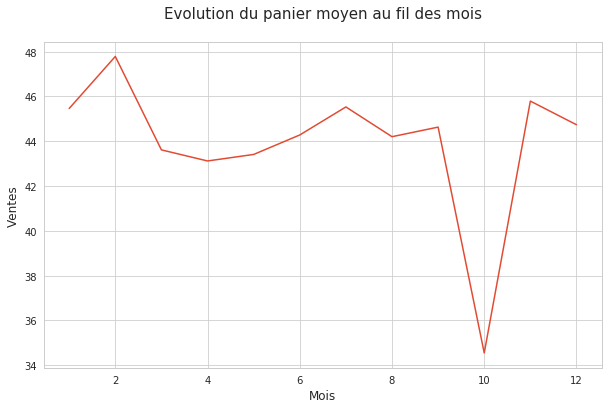

In [59]:
#Seaborn lineplot
sns.set_style('whitegrid')
line,ax = plt.subplots(figsize=(10,6))
ax = sns.lineplot(x="mois_achat", y="panier_moyen", data=data, ci = None);
ax.set_title("Evolution du panier moyen au fil des mois\n", fontsize=15)
ax.set_xlabel ("Mois")
ax.set_ylabel ("Ventes")
plt.savefig(dataPath+"ventes_mois.jpg")
plt.savefig("ventes_mois.png")

In [124]:
#data['panier_moyen'].max()
# Transactions les plus "juteuses"
data.loc[data['panier_moyen'] == 539.23]

,annee_achat,mois_achat,id_prod,categ,price,panier_moyen,session_id,sex,age,groupe_age
334102,2021,11,2_166,2,230.04,539.23,s_123227,f,28,jeunes
334103,2021,11,2_228,2,225.17,539.23,s_123227,f,28,jeunes
334104,2021,11,2_138,2,84.02,539.23,s_123227,f,28,jeunes


## Analyses bivariées

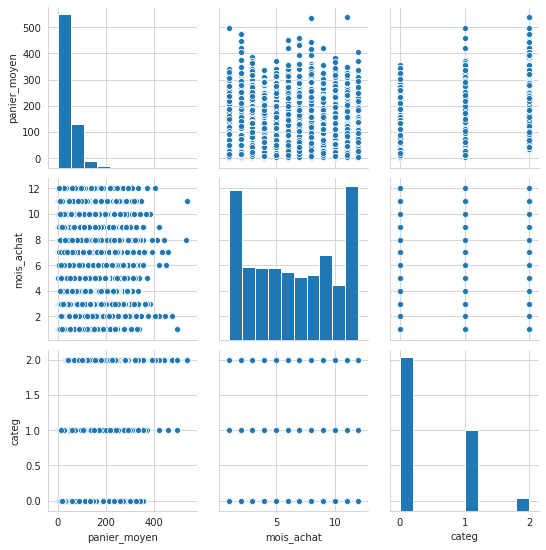

In [81]:
bivars = data[['panier_moyen','mois_achat','categ','sex','groupe_age']]
sns.pairplot(bivars)

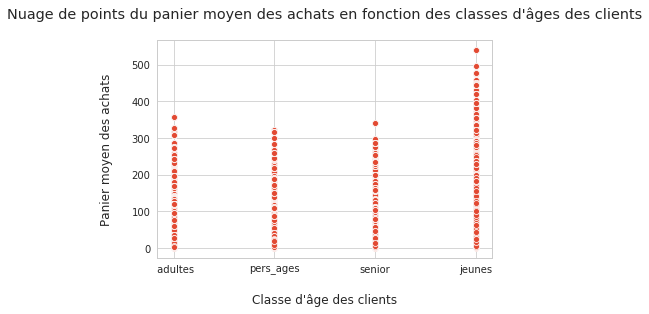

In [62]:
 
sns.scatterplot(data = data, x = "groupe_age", y = "panier_moyen")
plt.title("Nuage de points du panier moyen des achats en fonction des classes d'âges des clients\n") 
plt.xlabel('\nClasse d\'âge des clients')
plt.ylabel('Panier moyen des achats\n')

plt.savefig(dataPath+"nuage_pts_age.jpg")
plt.savefig("nuage_pts_age.png")

plt.show()

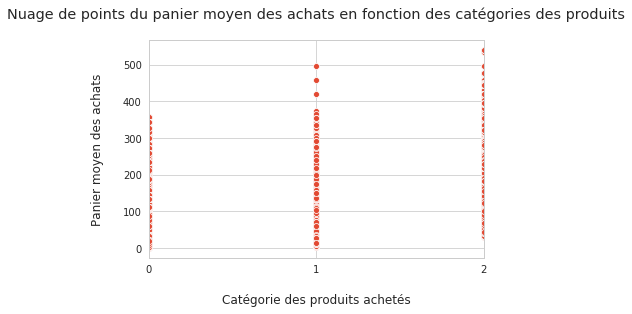

In [75]:
sns.scatterplot(data = data, x = "categ", y = "panier_moyen")

plt.title("Nuage de points du panier moyen des achats en fonction des catégories des produits\n") 
plt.xlabel('\nCatégorie des produits achetés')
plt.ylabel('Panier moyen des achats\n')

plt.savefig(dataPath+"nuage_pts_categ.jpg")
plt.savefig("nuage_pts_categ.png")

plt.xlim(0, 2)
plt.xticks([0, 1, 2])


plt.show()

<Figure size 432x432 with 0 Axes>

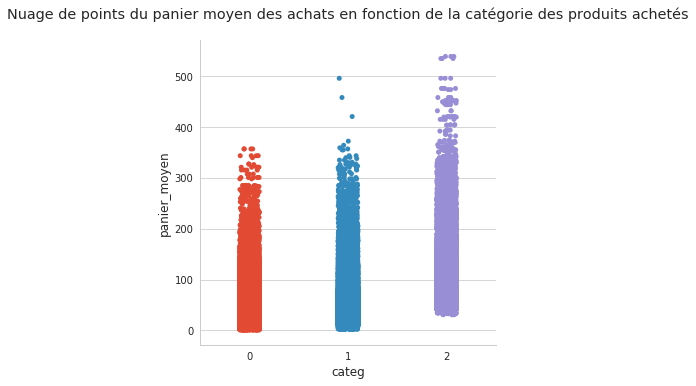

In [92]:
plt.figure(figsize=(6,6))

sns.catplot("categ", "panier_moyen", data=data)
plt.title("Nuage de points du panier moyen des achats en fonction de la catégorie des produits achetés\n") 

plt.savefig(dataPath+"nuage_pts_categ.jpg")
plt.savefig("nuage_pts_categ.png")
plt.show()


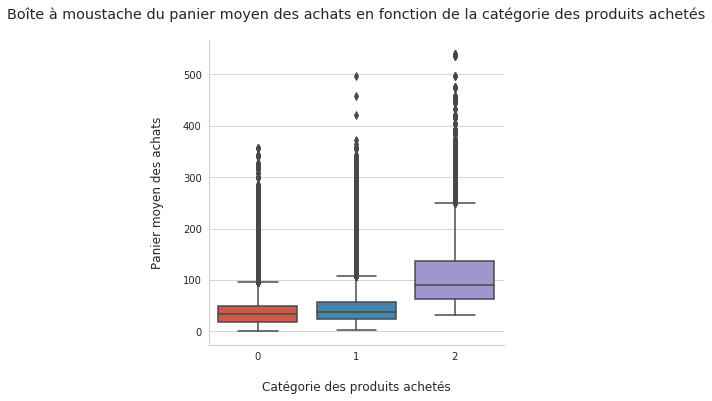

In [99]:
#plt.figure(figsize=(10,10))

sns.catplot(x="categ", y="panier_moyen", data=data, kind='box')
plt.xlabel('\nCatégorie des produits achetés')
plt.ylabel('Panier moyen des achats\n')
plt.title("Boîte à moustache du panier moyen des achats en fonction de la catégorie des produits achetés\n") 
plt.savefig(dataPath+"boite_moust_categ.jpg")
plt.savefig("boite_moust_categ.png")
plt.show()

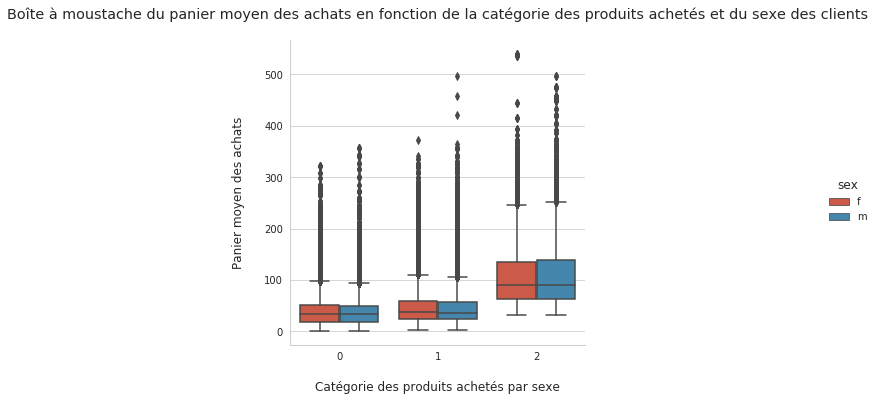

In [103]:
# plt.figure(figsize=(10,10))

sns.catplot(x="categ", y="panier_moyen", hue = 'sex', data=data, kind='box')
plt.xlabel('\nCatégorie des produits achetés par sexe')
plt.ylabel('Panier moyen des achats\n')
plt.title("Boîte à moustache du panier moyen des achats en fonction de la catégorie des produits achetés et du sexe des clients\n") 

plt.savefig(dataPath+"boite_moust_categ_sex.jpg")
plt.savefig("boite_moust_categ_sex.png")
plt.show()

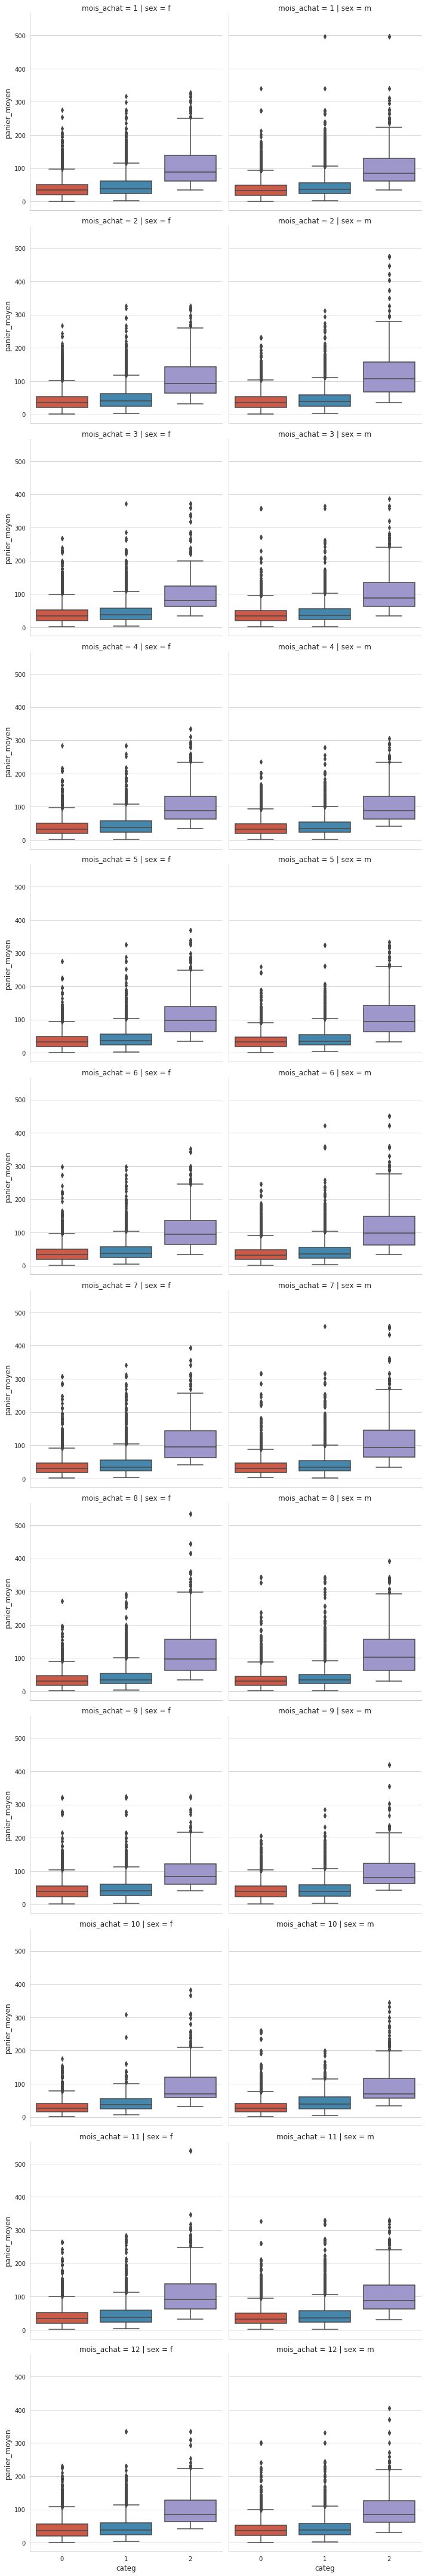

In [97]:

ax = sns.catplot(x="categ", y="panier_moyen", col = 'sex', row ='mois_achat', data=data, kind='box')

ax
plt.show()

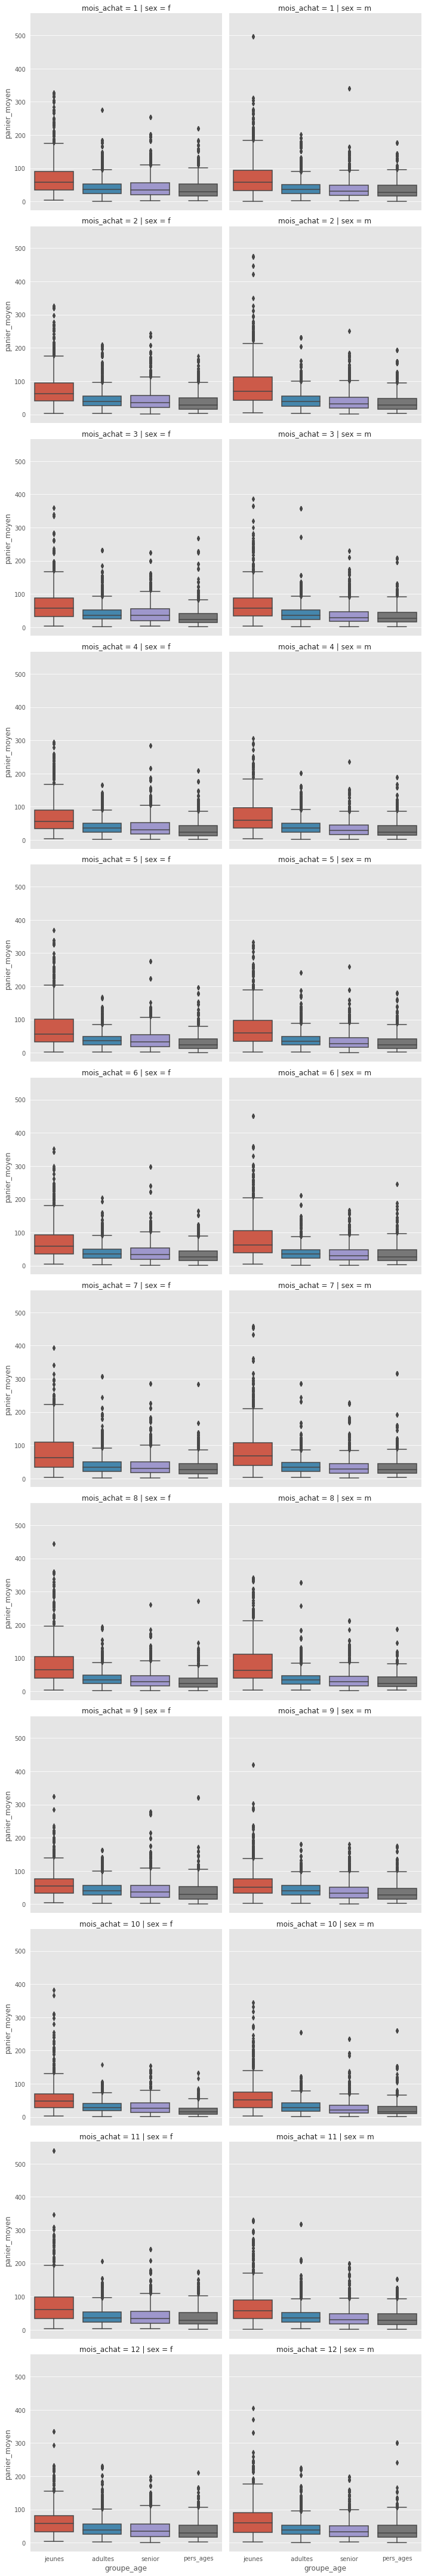

In [149]:

ax = sns.catplot(x="groupe_age", y="panier_moyen", col = 'sex', row ='mois_achat', data=data, kind='box')

ax
plt.show()

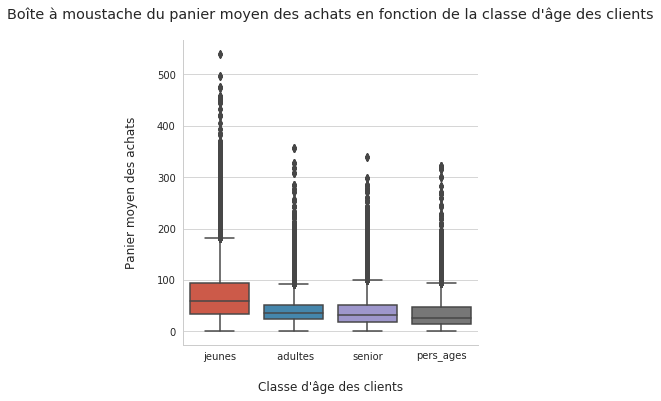

In [104]:
ax = sns.catplot(x="groupe_age", y="panier_moyen", data=data, kind='box')
plt.xlabel('\nClasse d\'âge des clients')
plt.ylabel('Panier moyen des achats\n')

plt.title("Boîte à moustache du panier moyen des achats en fonction de la classe d'âge des clients\n") 

plt.savefig(dataPath+"boite_moust_categ.jpg")
plt.savefig("boite_moust_categ.png")
plt.show()

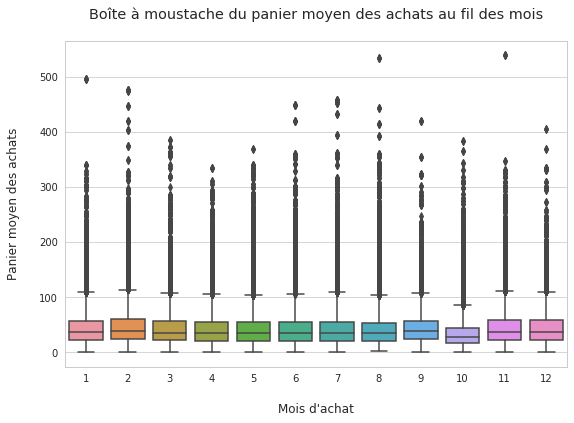

In [106]:
plt.figure(figsize=(9,6))

sns.boxplot(x='mois_achat', y='panier_moyen', data=data)

plt.xlabel('\nMois d\'achat')
plt.ylabel('Panier moyen des achats\n')
plt.title("Boîte à moustache du panier moyen des achats au fil des mois\n") 

plt.savefig(dataPath+"boite_moust_mois.jpg")
plt.savefig("boite_moust_mois.png")

plt.show()

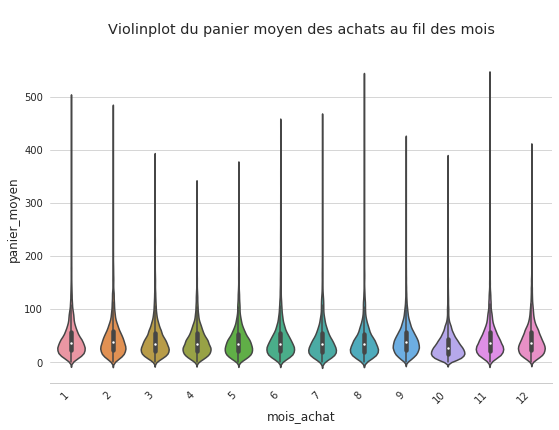

In [185]:
# Change to a bit better style and larger figure.
sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(9, 6))

# Plot our violins.
sns.violinplot(x='mois_achat', y='panier_moyen', data=data)
plt.title("\nViolinplot du panier moyen des achats au fil des mois\n") 

# Rotate the x-axis labels and remove the plot border on the left.
_ = plt.xticks(rotation=45, ha='right')
sns.despine(left=True)

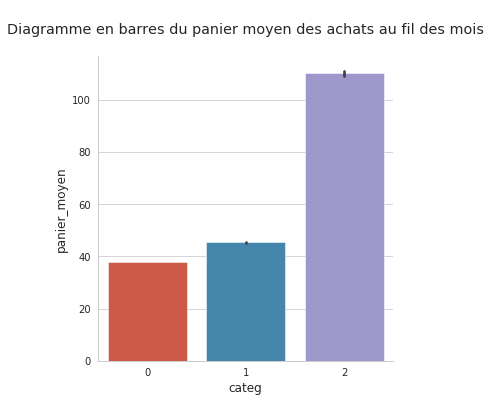

In [187]:
# Diagramme en bâtons par catégorie de produits

sns.set_style('whitegrid')

# sns.catplot(x="categ", y="CA", row = 'groupe_age',col = 'sex', data=tab_globale_reorg, kind='box')

sns.catplot(x="categ", y="panier_moyen", data=data, kind='bar')
plt.title("\nDiagramme en barres du panier moyen des achats au fil des mois\n") 

plt.show()

Text(30.602560763888896, 0.5, '\nPanier moyen des achats')

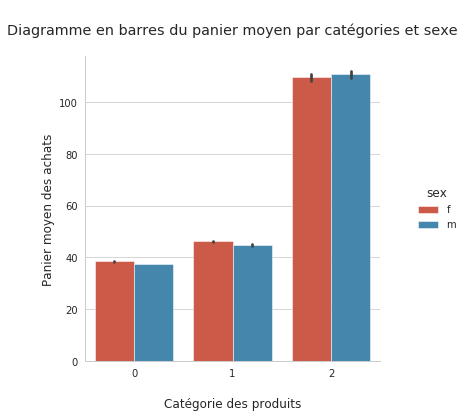

In [188]:
# Panier moyen par catégorie et par sexe

sns.catplot(x="categ", y="panier_moyen", data=data, hue = 'sex', kind='bar')
plt.title("\nDiagramme en barres du panier moyen par catégories et sexe\n")
plt.xlabel('\nCatégorie des produits')
plt.ylabel('\nPanier moyen des achats')



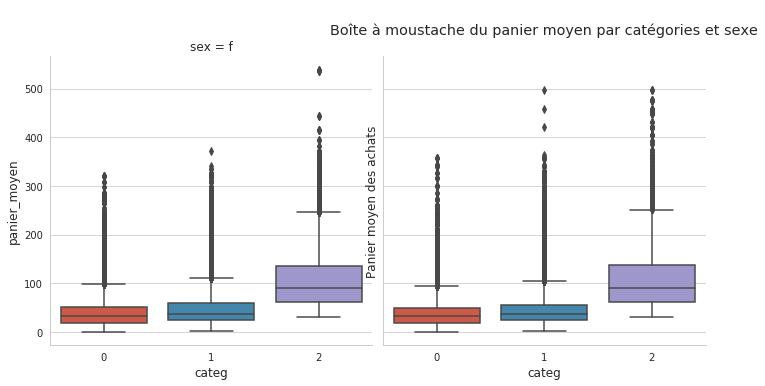

In [190]:
# Répartition du panier moyen par catégorie, par sexe et par groupe d'âge

#sns.catplot(x="categ", y="CA", data=tab_globale_reorg, col = 'groupe_age', hue = 'sex', kind='bar')
sns.catplot(x="categ", y="panier_moyen",col = 'sex', data=data, kind='box')

plt.title('\nBoîte à moustache du panier moyen par catégories et sexe\n')
plt.ylabel('\nPanier moyen des achats')
plt.show()

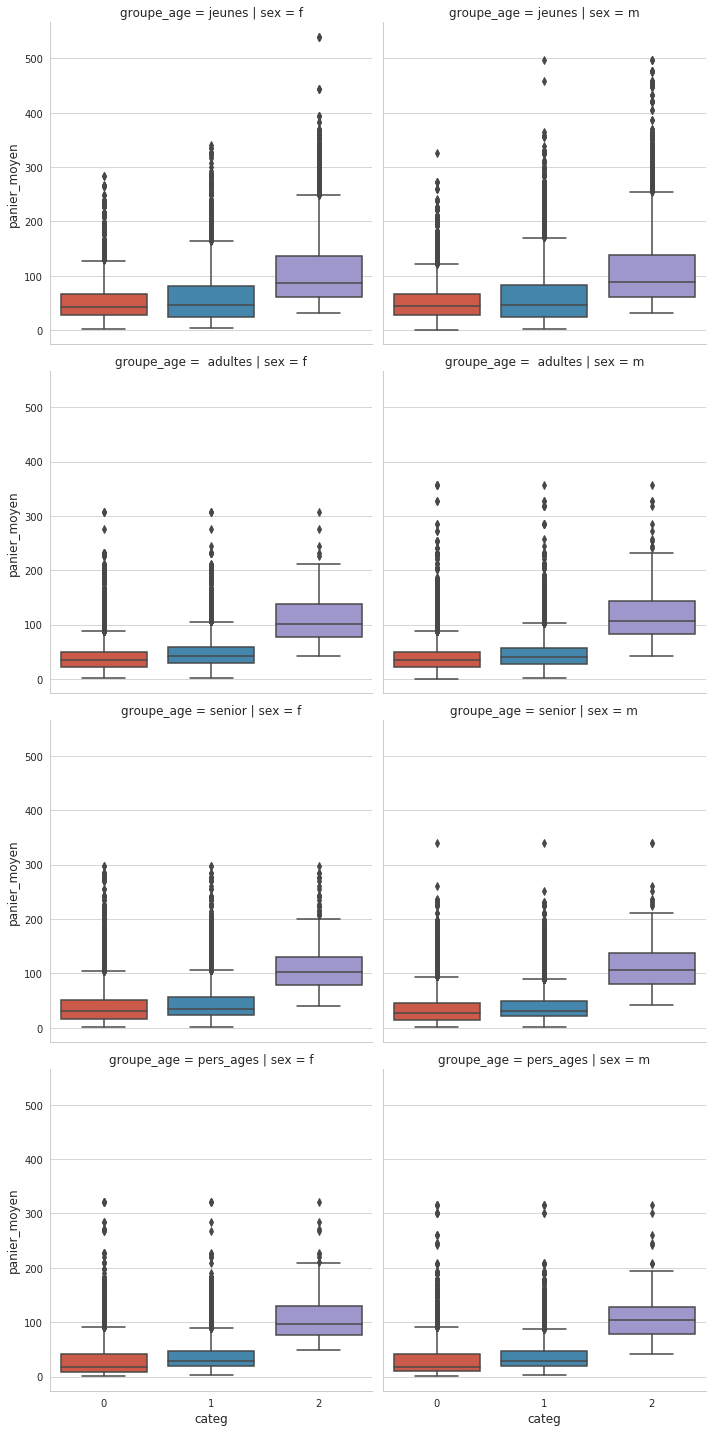

In [191]:
# Boîte à moustache par groupe d'âge et par sexe
# plt.subplots(figsize=(10,6))

sns.catplot(x="categ", y="panier_moyen", row = 'groupe_age',col = 'sex', data=data, kind='box')
plt.show()

In [165]:
# Corrélation entre les variables 

bivars = data[['categ','price','panier_moyen','age']] # Sélection des variables significatives
corr = bivars.corr()

print('\nTable des corrélations entre les variables significatives\n')
corr


Table des corrélations entre les variables significatives



,categ,price,panier_moyen,age
categ,1.000000,0.673359,0.350223,-0.098612
price,0.673359,1.000000,0.539566,-0.211529
panier_moyen,0.350223,0.539566,1.000000,-0.250606
age,-0.098612,-0.211529,-0.250606,1.000000


# Mission 3

## Y a-t-il une corrélation entre le sexe des clients et les catégories de produits achetés ?

In [126]:
# Deux variables qualitatives(tranche d'âge et catégorie de produit acheté) 

 # Générer un tableau de contingence
 # Heatmap
 # Khi-2

# =================================================   Test de khi-2   ==========================================================

# Deux variables qualitatives. Une variable influence une autre variable?  ==+> Test du Khi 2 (χ²)
# La variable dépendante est celle qui peut changer : 'categ'.
# La variable indépendante, est celle qui ne peut changer chez l’individu :'sex'

# Hypothèse nulle   : Il n’y a pas de lien.
# Hypothèse valable : Il y a un lien.

# Trouver le degré de liberté : il faut trouver les valeurs dépendantes dans ces lignes et colonnes du tableau. 
# Cela s’obtient en multipliant le nombre de lignes du tableau moins un par le nombre de colonnes moins un 
# Pour chaque ligne il y a 2-1 = 1 variables indépendantes, et pour chaque colonne il y a 4-1 = 3  variable indépendante. ????
# Ce qui conduit à  1*3 = 3 degrés de liberté.

# Choisir le risque de se tromper, c’est-à-dire de rejeter à tort l'hypothèse nulle. 5 % de chance de se tromper est le seuil de probabilité le plus souvent choisi. 


**1 - Tableau de contingence**

In [127]:
X = "sex"
Y = "categ"

cont = data[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
cont

categ,0,1,2,Total
sex,,,,
f,103786,55469,8260,167515
m,105640,54266,9292,169198
Total,209426,109735,17552,336713


**2 - Heatmap**

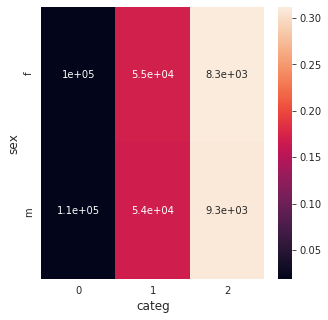

In [128]:
# Heatmap
plt.figure(figsize=(5,5))
tx = cont.loc[:,["Total"]]
ty = cont.loc[["Total"],:]
n = len(data)
indep = tx.dot(ty) / n

c = cont.fillna(0) # On remplace les valeurs nulles par 0
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1])
plt.show()

**3 - Khi-2**

In [129]:
# Deux variables qualitatives ===> calculer khi-2

chi2, pvalue, degrees, expected = chi2_contingency(cont)
chi2, degrees, pvalue

print('\nkhi-2 : {}  \nDegré de liberté : {}  \npvalue : {}'.format(chi2,degrees,pvalue))


khi-2 : 81.86933350990711  
Degré de liberté : 6  
pvalue : 1.467788236006804e-15


## Corrélations avec l'âge

### Y a-t-il une corrélation entre l\'âge des clients  et le montant total des achats

In [117]:
# Une variable qualitative ordinale(tranche d'âge) et une variable quantitatiave(total des achats) ===> ANOVA

# Hypothèse H0 : Il n'y a pas de lien entre la tranche d'âge des clients et le montant total des achats
# Hypothèse H1 : Il y a un lien entre la tranche d'âge des clients et le montant total des achats

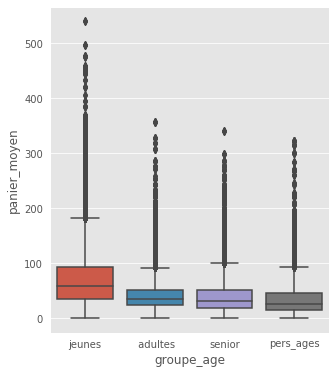

In [126]:
plt.figure(figsize=(5,6))
sns.boxplot(x='groupe_age', y='panier_moyen', data=data)
plt.show()

**Boîtes à moustaches panier moyen en fonction des tranches d'âges  ===> on note une différence 
entre les montants de panier moyen suivant les tranches d'âges**

**ANOVA**

In [127]:
mod = ols('panier_moyen ~ groupe_age', data=data).fit()
anova_table = anova_lm(mod, type=2)
print('\nTable ANOVA\n')
print(anova_table)


Table ANOVA

                  df        sum_sq       mean_sq             F  PR(>F)
groupe_age       3.0  4.204995e+07  1.401665e+07  13505.883506     0.0
Residual    329361.0  3.418168e+08  1.037818e+03           NaN     NaN


**p = 0 ===> H0 rejeté ===> Il existe bien un lien entre la tranche d\'âge des clients et le montant total des achats**

## Y a-t-il une corrélation entre l'âge des clients et la fréquence d’achat (ie. nombre d'achats par mois par exemple)

**Une variable qualitative ordinale(tranche d\'âge) et une variable quantitatiave
(fréquence d'achats, nombre d'achats par mois) ===> ANOVA**


In [166]:
# Boîtes à moustaches nombre d'achats par mois en fonction des tranche d'âge  

# Hypothèse H0 : Il n'y a pas de lien entre la tranche d'âge des clients et le montant total des achats
# Hypothèse H1 : Il y a un lien entre la tranche d'âge des clients et le montant total des achats

**Calcul du nombre d\'achats effectués par mois**

In [167]:
data['nb_achat'] = 1
nb_session_achat_mois = data[['mois_achat','nb_achat','session_id']]
nbre_achat_mois = nb_session_achat_mois.groupby(['mois_achat']).sum()
nbre_achat_mois_reset_index = nbre_achat_mois.reset_index()
nbre_achat_mois_reset_index

,mois_achat,nb_achat
0,1,29311
1,2,29556
2,3,28559
3,4,28401
4,5,28237
5,6,26812
6,7,24712
7,8,25610
8,9,33254
9,10,21577


In [168]:
# Jointure de la table du nombre de ventes avec celle des données globales

s = pd.merge(nbre_achat_mois_reset_index, data, on = 'mois_achat')

In [169]:
# Correction de la table issue de la jointure

s.rename(columns={'nb_achat_x':'nb_achat_mois'}, inplace=True)
u = s.drop('nb_achat_y', axis=1)
u

,mois_achat,nb_achat_mois,annee_achat,id_prod,categ,price,panier_moyen,session_id,sex,age,groupe_age
0,1,29311,2022,0_1152,0,10.70,57.66,s_146917,f,44,adultes
1,1,29311,2022,1_685,1,15.99,57.66,s_146917,f,44,adultes
2,1,29311,2022,1_673,1,12.99,57.66,s_146917,f,44,adultes
3,1,29311,2022,0_1785,0,8.99,57.66,s_146917,f,44,adultes
4,1,29311,2022,0_1167,0,8.99,57.66,s_146917,f,44,adultes
...,...,...,...,...,...,...,...,...,...,...,...
336708,12,32417,2021,0_138,0,19.95,33.85,s_128952,m,22,jeunes
336709,12,32417,2021,1_378,1,26.61,26.61,s_134917,f,42,adultes
336710,12,32417,2021,1_353,1,26.99,26.99,s_138116,m,58,senior
336711,12,32417,2021,0_153,0,3.99,3.99,s_139571,f,83,pers_ages


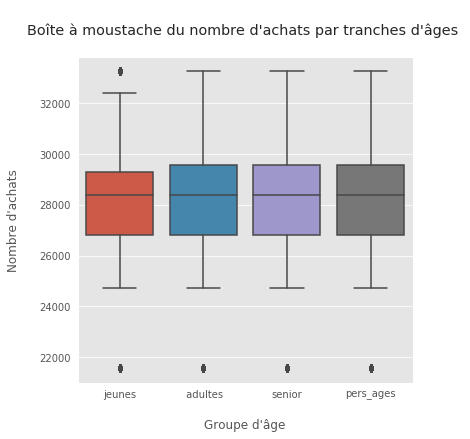

In [170]:
# Boîtes à moustaches nombre d'achats effectués par mois en fonction des tranches d'âge  ===> on note peu de différences 
# entre le nombre d'achats effectués par mois  en les groupes d'âges ??????

plt.figure(figsize=(6,6))
sns.boxplot(x='groupe_age', y='nb_achat_mois', data=u)
plt.title('\nBoîte à moustache du nombre d\'achats par tranches d\'âges \n')
plt.xlabel('\nGroupe d\'âge')
plt.ylabel('Nombre d\'achats\n')

plt.show()

**ANOVA**

In [171]:
# ANOVA
mod = ols('nb_achat_mois ~ groupe_age', data=u).fit()
anova_table = anova_lm(mod, type=2)
print('\nTable ANOVA\n')
print(anova_table)


Table ANOVA

                  df        sum_sq       mean_sq          F        PR(>F)
groupe_age       3.0  3.495135e+09  1.165045e+09  131.47958  3.987772e-85
Residual    329361.0  2.918479e+12  8.861034e+06        NaN           NaN


**Hypothèse H0 retenu ===> Il n\'y a pas de lien entre la tranche d'âge des clients et le montant total des achats**

## Y a-t-il une corrélation entre l'âge des clients et la taille du panier moyen (en nombre d’articles)

In [172]:
# Hypothèse H0 : Il n'y a pas de lien entre l'âge des clients et la taille du panier moyen (en nombre d’articles)
# Hypothèse H1 : Il y a un lien entre l'âge des clients et la taille du panier moyen (en nombre d’articles)

**Calcul du nombre d\'articles achetés par produit**

In [173]:
nb_articles = data[['nb_achat','id_prod']]

nb_articles_mois = nb_articles.groupby(['id_prod']).sum()
nb_articles_mois_reset_index = nb_articles_mois.reset_index()
nb_articles_mois_reset_index.rename(columns={'nb_achat':'nb_articles'}, inplace=True)
nb_articles_mois_reset_index

,id_prod,nb_articles
0,0_0,611
1,0_1,249
2,0_10,12
3,0_100,2
4,0_1000,222
...,...,...
3259,2_95,3
3260,2_96,281
3261,2_97,5
3262,2_98,1


In [174]:
# Table prenant en compte le nombre d'articles achetés par mois

p = pd.merge(nb_articles_mois_reset_index, data, on = 'id_prod')
p

,id_prod,nb_articles,annee_achat,mois_achat,categ,price,panier_moyen,session_id,sex,age,groupe_age,nb_achat
0,0_0,611,2022,2,0,3.75,16.36,s_170042,f,39,adultes,1
1,0_0,611,2021,3,0,3.75,29.98,s_10114,m,41,adultes,1
2,0_0,611,2022,2,0,3.75,21.16,s_161224,m,41,adultes,1
3,0_0,611,2021,9,0,3.75,39.23,s_98147,m,41,adultes,1
4,0_0,611,2021,12,0,3.75,51.79,s_138628,m,41,adultes,1
...,...,...,...,...,...,...,...,...,...,...,...,...
336708,2_97,5,2021,4,2,160.99,160.99,s_16930,m,25,jeunes,1
336709,2_97,5,2022,1,2,160.99,160.99,s_157815,f,18,jeunes,1
336710,2_98,1,2021,3,2,149.74,149.74,s_3637,f,18,jeunes,1
336711,2_99,2,2021,7,2,84.99,84.99,s_61009,m,25,jeunes,1


In [175]:
# Article le plus vendu

p['nb_articles'].max()

1081

In [176]:
# Identification de l'article le plus vendu
p.loc[p['nb_articles'] == 1081]


,id_prod,nb_articles,annee_achat,mois_achat,categ,price,panier_moyen,session_id,sex,age,groupe_age,nb_achat
245151,1_369,1081,2021,7,1,23.99,125.09,s_61300,f,44,adultes,1
245152,1_369,1081,2021,3,1,23.99,116.83,s_4172,m,41,adultes,1
245153,1_369,1081,2021,12,1,23.99,39.98,s_133931,m,41,adultes,1
245154,1_369,1081,2021,3,1,23.99,59.52,s_3700,m,41,adultes,1
245155,1_369,1081,2021,10,1,23.99,66.82,s_111485,m,41,adultes,1
...,...,...,...,...,...,...,...,...,...,...,...,...
246227,1_369,1081,2022,2,1,23.99,38.72,s_170489,m,69,pers_ages,1
246228,1_369,1081,2022,2,1,23.99,93.98,s_171987,f,23,jeunes,1
246229,1_369,1081,2021,8,1,23.99,23.99,s_75756,m,55,senior,1
246230,1_369,1081,2021,11,1,23.99,23.99,s_114614,m,29,jeunes,1


In [177]:
#import qgrid
widget_ved = qgrid.show_grid(p, show_toolbar=True)
widget_ved

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

**Une variable qualitative ordinale(tranche d\'âge) et une variable quantitatiave(nombre d\'articles) ===> ANOVA**

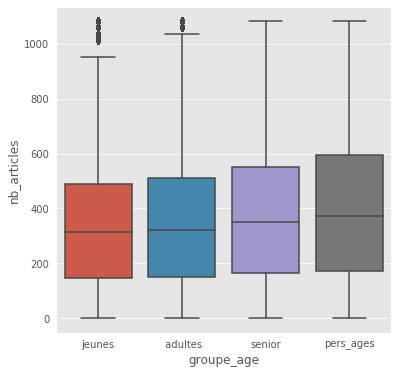

In [184]:
# Boîtes à moustaches 'nombre d'articles' en fonction des tranches d'âge  ===> on note une différence 
# entre les montants de panier moyen en les catégories

plt.figure(figsize=(6,6))
sns.boxplot(x='groupe_age', y='nb_articles', data=p)
plt.show()

**ANOVA**

In [179]:
# ANOVA
mod = ols('nb_articles ~ groupe_age', data=p).fit()
anova_table = anova_lm(mod, type=2)
print('\nTable ANOVA\n')
print(anova_table)


Table ANOVA

                  df        sum_sq       mean_sq           F  PR(>F)
groupe_age       3.0  1.564285e+08  5.214282e+07  843.312517     0.0
Residual    329361.0  2.036470e+10  6.183095e+04         NaN     NaN


**Hypothèse H0 rejeté ==> Il n'y a pas de lien entre l\'âge des clients et la taille du panier moyen (en nombre d’articles)**

**2.3 Y a-t-il une corrélation entre l'âge des clients et la taille du panier moyen (en nombre d'articles)**

## Y a-t-il une corrélation entre l'âge des clients et les catégories de produits achetés

In [180]:
# Deux variables qualitatives ===> Générer un tableau de contingence
# Heatmap
# Deux variables qualitatives(tranche d'âge et catégorie de produit acheté) ===> Khi-2

**1 - Table de contingence**

In [181]:
X = "groupe_age"
Y = "categ"

cont_a = data[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")
cont_a

categ,0,1,2,Total
groupe_age,,,,
jeunes,13274,13533,13248,40055
adultes,127806,37551,433,165790
senior,48897,34165,615,83677
pers_ages,17781,21727,335,39843
Total,207758,106976,14631,329365


**2 - Heatmap**

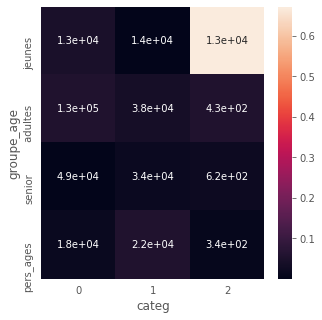

In [182]:
# Heatmap

plt.figure(figsize=(5,5))
tx = cont_a.loc[:,["Total"]]
ty = cont_a.loc[["Total"],:]
n = len(data)
indep = tx.dot(ty) / n

c = cont_a.fillna(0) # On remplace les valeurs nulles par 0
measure = (c-indep)**2/indep
xi_n = measure.sum().sum()
table = measure/xi_n
sns.heatmap(table.iloc[:-1,:-1],annot=c.iloc[:-1,:-1])
plt.show()

**3 - Khi-2**

In [183]:
# Khi-2
chi2, pvalue, degrees, expected = chi2_contingency(cont_a)
chi2, degrees, pvalue
print('\nkhi-2 : {}  \nDegré de liberté : {}  \npvalue : {}'.format(chi2,degrees,pvalue))


khi-2 : 110200.68893802552  
Degré de liberté : 12  
pvalue : 0.0
